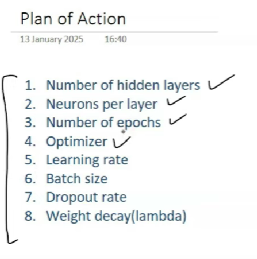

## Optuna code


first of all create an **Objective Function** :-Just like an python function

> 1. Search Space:

> 2. model  initialization:

> 3. parameter initialization:

> 4. training loop

> 5. Evaluation

This objective function is taking **trial object** as an argument of Optuna

- We create an study in optuna in which we decide the number of **trail** (how much time we have to train the model on our data)

- Then with the help of study object we create single **trail**

- Then this **trail** is sent into the objective Function

- Now after performing all functions from this **objective function** it return the **accuracy on test data set**



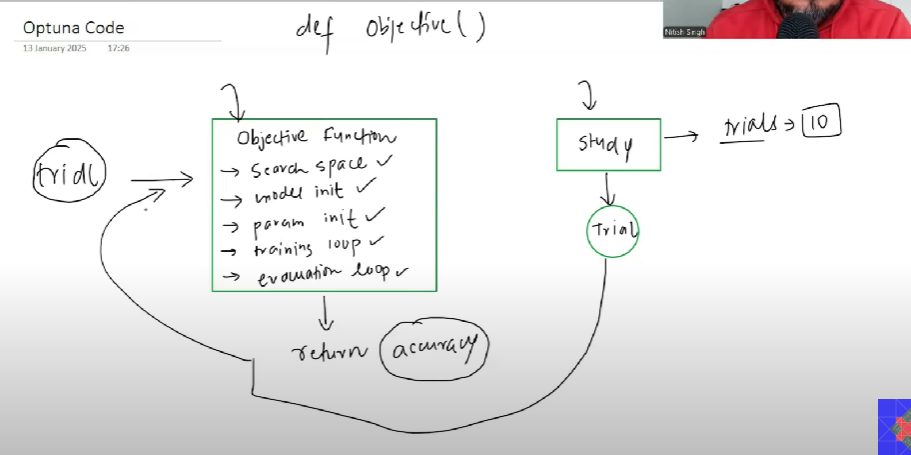









In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

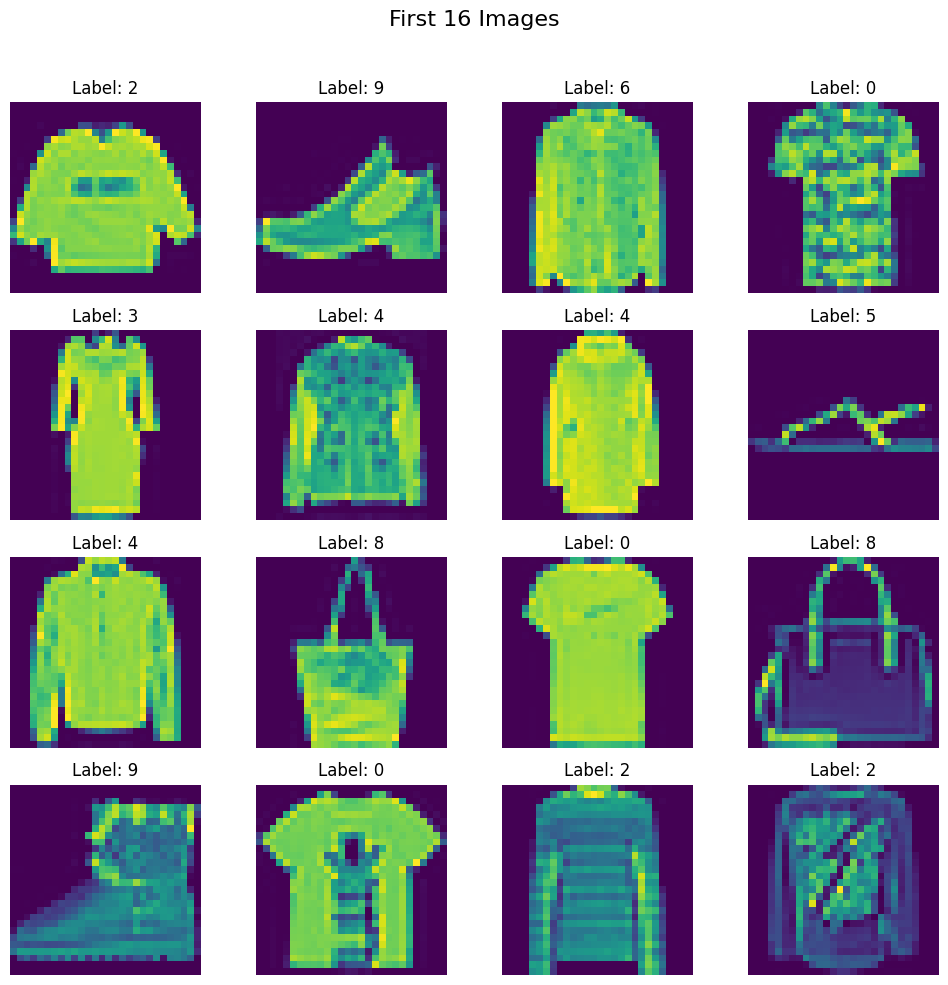

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [7]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [11]:
train_dataset = CustomDataset(X_train, y_train)

In [12]:
test_dataset = CustomDataset(X_test, y_test)

In [14]:
# Used only if we are using phase 1
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [15]:
# len(train_loader)

166

In [13]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

In [19]:
# Objective Function Phase 1
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer)
  model.to(device)

  # parameters init
  learning_rate = 0.01
  epochs = 150

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  # training loop
  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [14]:
# Objective Function Phase 2
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer=='Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer=='SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop
  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()

  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [15]:
# It will be used to create study
!pip install optuna

In [16]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-07-23 15:40:47,802] A new study created in memory with name: no-name-b9d4259c-8198-4cd9-91a9-639fa91b357b


In [17]:
study.optimize(objective, n_trials=10)

[I 2025-07-23 15:42:12,368] Trial 0 finished with value: 0.7133333333333334 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 16, 'epochs': 10, 'learning_rate': 0.0012854661765442823, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.0001351558692746321}. Best is trial 0 with value: 0.7133333333333334.
[I 2025-07-23 15:42:39,349] Trial 1 finished with value: 0.876 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 48, 'epochs': 10, 'learning_rate': 0.0013928694100236504, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 7.716056687123317e-05}. Best is trial 1 with value: 0.876.
[I 2025-07-23 15:43:59,012] Trial 2 finished with value: 0.8899166666666667 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 120, 'epochs': 20, 'learning_rate': 0.0019161104859417193, 'dropout_rate': 0.2, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.00013275894013963687}. Best is trial 2 with value: 0.8899166

In [18]:
study.best_value

0.8899166666666667

In [19]:
study.best_params

{'num_hidden_layers': 3,
 'neurons_per_layer': 120,
 'epochs': 20,
 'learning_rate': 0.0019161104859417193,
 'dropout_rate': 0.2,
 'batch_size': 128,
 'optimizer': 'Adam',
 'weight_decay': 0.00013275894013963687}

In [ ]:
# To increase accuracy we can do following things
# 1. Increasing the trials
# 2. Increasing the search space

## Experiment tracking during development using MLflowx